In [1]:
!pip install optuna

^C


In [2]:
# Import libraries
import numpy as np            # For numerical operations and linear algebra, such as array and matrix manipulations
import pandas as pd           # For data processing, including data manipulation and reading/writing CSV files (e.g., pd.read_csv)
import optuna                 # For automated hyperparameter tuning, which optimizes model parameters to improve accuracy
import logging                # For controlling and managing log outputs, especially useful in suppressing or capturing log messages
import seaborn as sns         # For data visualization, particularly for creating aesthetically pleasing statistical graphics
import matplotlib.pyplot as plt  # For general-purpose plotting, allows for custom charts and visualizations

import xgboost as xgb         # XGBoost library, used for efficient gradient boosting, which is popular for structured/tabular data
from xgboost import plot_importance, plot_tree  # Additional XGBoost functions for visualizing feature importance and decision trees

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Performance metrics for model evaluation, particularly useful for regression tasks

# Set color palette and style for visualizations
color_pal = sns.color_palette()    # Define a color palette for consistent styling across plots
plt.style.use('fivethirtyeight')   # Set plot style to 'fivethirtyeight' for a clean and professional look

In [4]:
# Load dataset
df = pd.read_csv('../sample_data/internet_details.csv')
# Keep only required columns
df = df[['startdate', 'item', 'service_type', 'bandwidth_in_gbps', 'peak_bandwidth_utilization']]
df = df.set_index("startdate")
df.index = pd.to_datetime(df.index)


In [5]:
df.head()

,item,service_type,bandwidth_in_gbps,peak_bandwidth_utilization
startdate,,,,
2025-06-15,PGW_Patan,PGW,100,57.86
2025-06-15,GOOGLE IPLC via Tata,IPLC_091DELH0020A0293820,10,9.87
2025-06-15,Google,cache,274,182.04
2025-06-15,AIRTEL IPT,IPT_14168059&14800249,52,46.86
2025-06-15,PGW_Biratnagar,PGW,30,26.87


In [6]:
df.tail()

,item,service_type,bandwidth_in_gbps,peak_bandwidth_utilization
startdate,,,,
2025-09-06,PGW_Hetauda,PGW,100,18.24
2025-09-06,BNG_Biratnagar,BNG,10,0.37
2025-09-06,Google,cache,259,206.55
2025-09-06,AIRTEL IPT,IPT_14837544,10,10.71
2025-09-06,GOOGLE IPLC via Tata,IPLC_977KATH0020A0130543,10,9.65


In [7]:
#Lets test for Google/Cache combination
df_google = df[(df['item'] == 'Google') &
               (df['service_type'] == 'cache')]

# Sort by date
df_google = df_google.sort_values('startdate')

In [8]:
df_google.head()

,item,service_type,bandwidth_in_gbps,peak_bandwidth_utilization
startdate,,,,
2025-06-15,Google,cache,274,182.04
2025-06-16,Google,cache,274,188.51
2025-06-17,Google,cache,274,189.46
2025-06-18,Google,cache,274,184.00
2025-06-19,Google,cache,274,189.45


In [9]:
df_google.tail()

,item,service_type,bandwidth_in_gbps,peak_bandwidth_utilization
startdate,,,,
2025-09-02,Google,cache,259,187.99
2025-09-03,Google,cache,259,191.97
2025-09-04,Google,cache,259,220.56
2025-09-05,Google,cache,259,222.43
2025-09-06,Google,cache,259,206.55


In [10]:
df_google.size

336

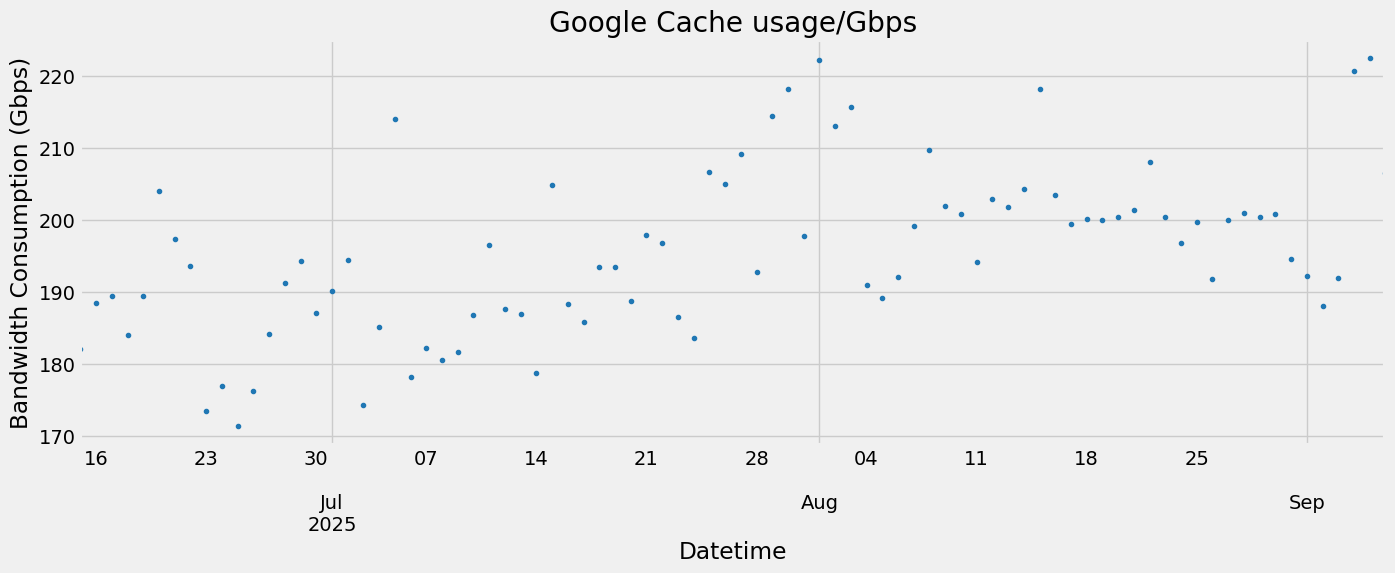

In [11]:
# Plotting the peak bandwidth utilization
ax = df_google['peak_bandwidth_utilization'].plot(
    style=".",                    # Use dots to represent each data point on the plot
    figsize=(15, 5),              # Set the figure size to 15 inches wide by 5 inches tall
    color=color_pal[0],           # Use the first color from the color palette for the plot points
    title="Google Cache usage/Gbps" # Set the title of the plot to indicate the data being displayed
)

# Add axis labels
ax.set_xlabel("Datetime")
ax.set_ylabel("Bandwidth Consumption (Gbps)")

# Display the plot
plt.show()

Train set shape: (68, 4)
Test set shape: (16, 4)


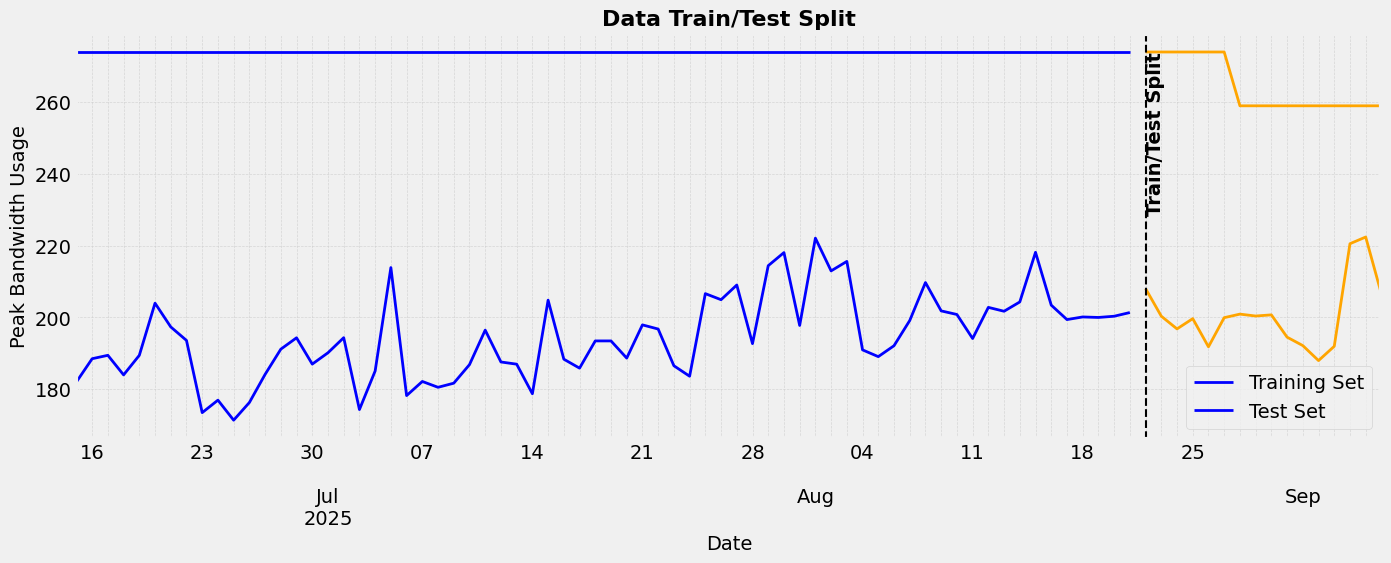

In [12]:
# Splitting the dataset into training and testing sets based on a date condition

train = df_google.loc[df_google.index < '2025-08-22']
test = df_google.loc[df_google.index >= '2025-08-22']

print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot training and test sets with customized colors
train.plot(ax=ax, label='Training Set', color='blue', linewidth=2)
test.plot(ax=ax, label='Test Set', color='orange', linewidth=2)

# Add vertical line for split date with annotation
split_date = '2025-08-22'
ax.axvline(split_date, color='black', linestyle='--', linewidth=1.5)
ax.text(split_date, ax.get_ylim()[1] * 0.9, 'Train/Test Split',
        rotation=90, color='black', verticalalignment='center', fontweight='bold')

# Customize title and labels
ax.set_title('Data Train/Test Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Peak Bandwidth Usage', fontsize=14)

# Display grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend and show plot
ax.legend(['Training Set', 'Test Set'])
plt.show()

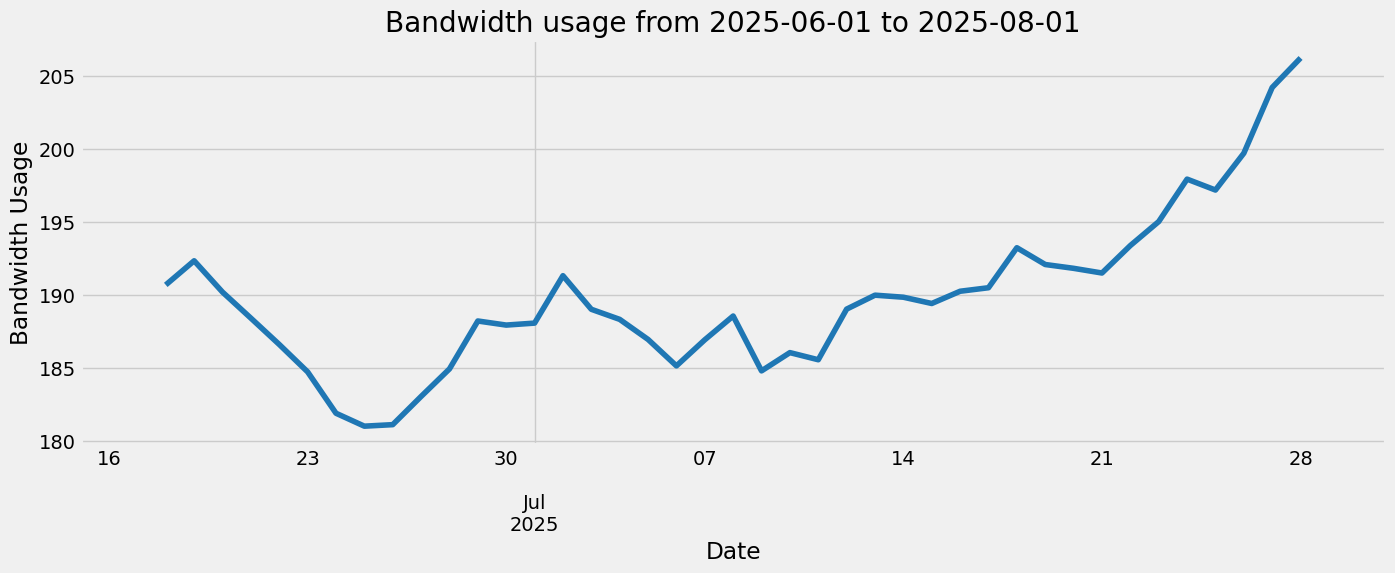

In [13]:
# Filter the DataFrame based on the date range
filtered_df = df_google.loc[(df_google.index > "2025-06-01") & (df_google.index < "2025-08-01")]
# Apply a 7-day rolling average to smooth the data
smoothed_df = filtered_df["peak_bandwidth_utilization"].rolling(window=7, center=True).mean()

# Plot the smoothed data
ax = smoothed_df.plot(figsize=(15, 5), title="Bandwidth usage from 2025-06-01 to 2025-08-01", color=color_pal[0])

# Add additional plot information for clarity
ax.set_xlabel("Date")  # X-axis label
ax.set_ylabel("Bandwidth Usage")  # Y-axis label
ax.grid(True)  # Enable grid for better readability

plt.show()

In [14]:
def create_features(df):
    # Existing features
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month

    # Additional features
    df["dayofmonth"] = df.index.day              # Day of the month (1 to 31)
    df["is_weekend"] = df.index.dayofweek == 5    # Binary feature for Saturday (1 if Saturday, else 0)
    df["is_friday"] = df.index.dayofweek == 4     # Binay feature for Friday
    df["is_month_start"] = df.index.is_month_start # Binary feature for start of month
    df["is_month_end"] = df.index.is_month_end     # Binary feature for end of month
    df["is_year_start"] = df.index.is_year_start   # Binary feature for start of year
    df["is_year_end"] = df.index.is_year_end       # Binary feature for end of year

    # Cyclical features (useful for capturing seasonality patterns)
    df["sin_dayofweek"] = np.sin(2 * np.pi * df["dayofweek"] / 7)  # Sine transformation for day of the week
    df["cos_dayofweek"] = np.cos(2 * np.pi * df["dayofweek"] / 7)  # Cosine transformation for day of the week
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)  # Sine transformation for month
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)  # Cosine transformation for month

    return df

df = create_features(df_google)

/var/folders/fc/63smr92n7jz_753ds3rq4j6w0000gn/T/ipykernel_3661/2055509140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="dayofweek", y="peak_bandwidth_utilization", ax=ax, palette="coolwarm")  # Adjust color with a palette


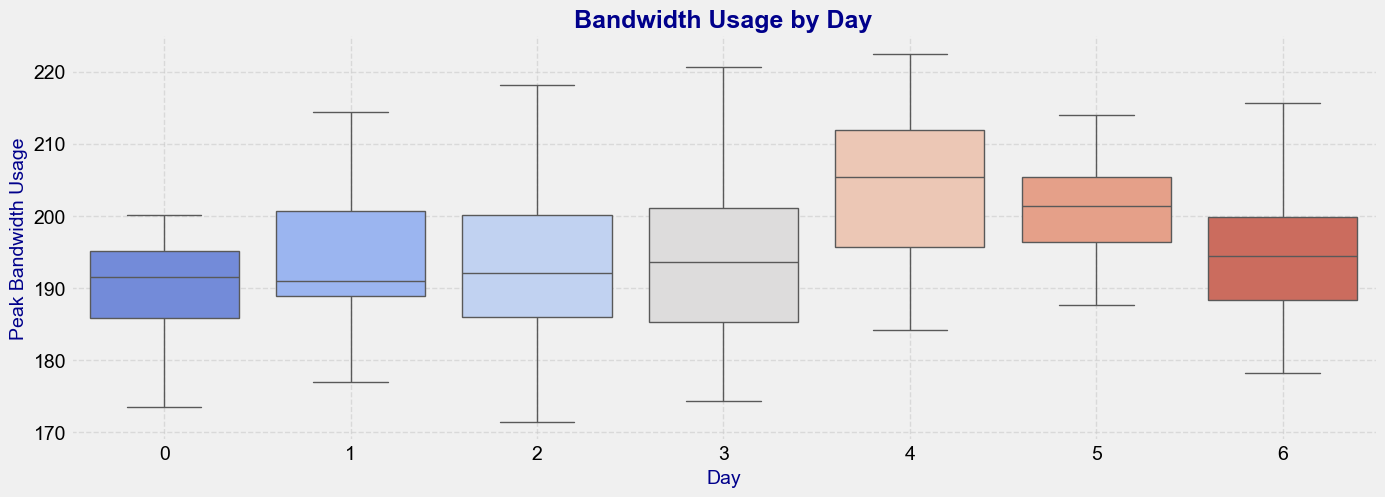

In [15]:
# Set a larger figure size and style
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style("whitegrid")  # Set the background style to whitegrid for a cleaner look

# Use a color palette for the boxplot
sns.boxplot(data=df, x="dayofweek", y="peak_bandwidth_utilization", ax=ax, palette="coolwarm")  # Adjust color with a palette

# Add a title and style it
ax.set_title("Bandwidth Usage by Day", fontsize=18, fontweight="bold", color="darkblue")

# Customize the x and y axis labels
ax.set_xlabel("Day", fontsize=14, color="darkblue")
ax.set_ylabel("Peak Bandwidth Usage", fontsize=14, color="darkblue")

# Add gridlines for better readability
ax.grid(True, linestyle="--", alpha=0.6)

# Remove the top and right spines to give the plot a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.show()

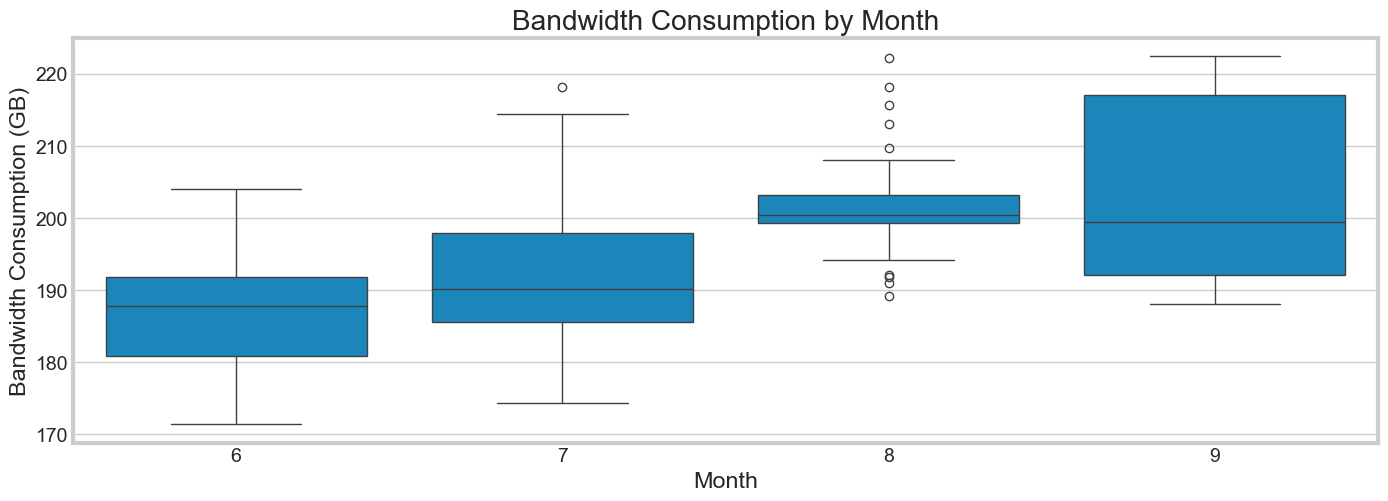

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))  # Use plt.subplots instead of plt.subplot
sns.boxplot(data=df, x="month", y="peak_bandwidth_utilization", ax=ax)  # Pass ax to sns.boxplot
ax.set_title("Bandwidth Consumption by Month")
ax.set_xlabel("Month")  # Optional: Label the x-axis
ax.set_ylabel("Bandwidth Consumption (GB)")  # Optional: Label the y-axis
plt.show()

In [18]:
# Apply feature engineering to train and test sets
train = create_features(train)
test = create_features(test)

# Define features and target
TARGET = "peak_bandwidth_utilization"
FEATURES = [
    "dayofweek", "month",
    "dayofmonth", "is_weekend", "is_friday", "is_month_start",
    "is_month_end","is_year_start",
    "is_year_end", "sin_dayofweek", "cos_dayofweek",
    "sin_month", "cos_month"
]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

Test RMSE: 7.657930578914228


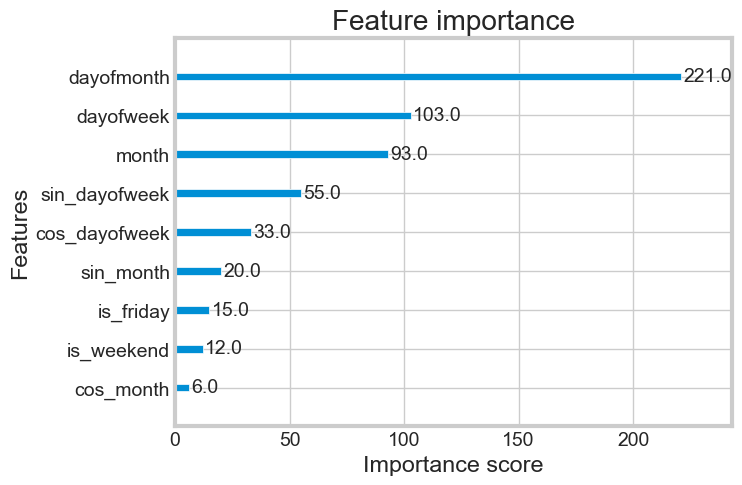

In [19]:
# Suppress Optuna's output by setting the logging level to WARNING
optuna.logging.set_verbosity(logging.WARNING)

# Optuna objective function for hyperparameter tuning
def objective(trial):
    """
    Defines the objective function for Optuna hyperparameter tuning of the XGBRegressor model.

    Parameters:
    - trial: An Optuna Trial object which suggests values for the hyperparameters.

    Returns:
    - rmse: The Root Mean Squared Error (RMSE) on the test set, used as the objective to minimize.
    """

    # Define the hyperparameters with search spaces for Optuna to optimize
    param = {
        "n_estimators": 1000,  # Set a high number of estimators, allowing early stopping to determine optimal rounds
        "early_stopping_rounds": 50,  # Stops training if there's no improvement for 50 rounds
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),  # Controls step size, log scale
        "max_depth": trial.suggest_int("max_depth", 3, 10),  # Limits tree depth to control complexity
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Minimum sum of weights in a child node
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of data for each tree to avoid overfitting
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features per tree
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),  # Minimum loss reduction for split, log scale
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),  # L2 regularization, log scale
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),  # L1 regularization, log scale
        "eval_metric": "rmse"  # Evaluation metric set to RMSE (Root Mean Squared Error)
    }

    # Initialize the XGBRegressor model with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)

    # Fit the model on the training set, with the validation set for early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Use test set as a validation set for early stopping
        verbose=False  # Suppress output to keep the output clean
    )

    # Predict on the test set and calculate RMSE as the objective value
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # Calculate RMSE to evaluate model performance

    return rmse  # Return RMSE as the value to be minimized by Optuna

# Run Optuna optimization
study = optuna.create_study(direction="minimize")  # Create an Optuna study to minimize RMSE
study.optimize(objective, n_trials=50)  # Run 50 trials of hyperparameter optimization

# Train final model with best parameters
# Retrieve the best parameters found by Optuna and set additional fixed parameters
best_params = study.best_params
best_params["n_estimators"] = 1000
best_params["early_stopping_rounds"] = 50
best_params["eval_metric"] = "rmse"

# Initialize and train the final model using the best-found hyperparameters
model = xgb.XGBRegressor(**best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Use the test set as a validation set for early stopping
    verbose=False  # Suppress output for a clean log
)

# Evaluate the model
# Generate predictions on the test set and calculate the RMSE to assess performance
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Test RMSE:", rmse)  # Print the final RMSE on the test set

# Plot feature importance
# Visualize the top 10 most important features to understand which features contributed most to the model's predictions
xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.show()

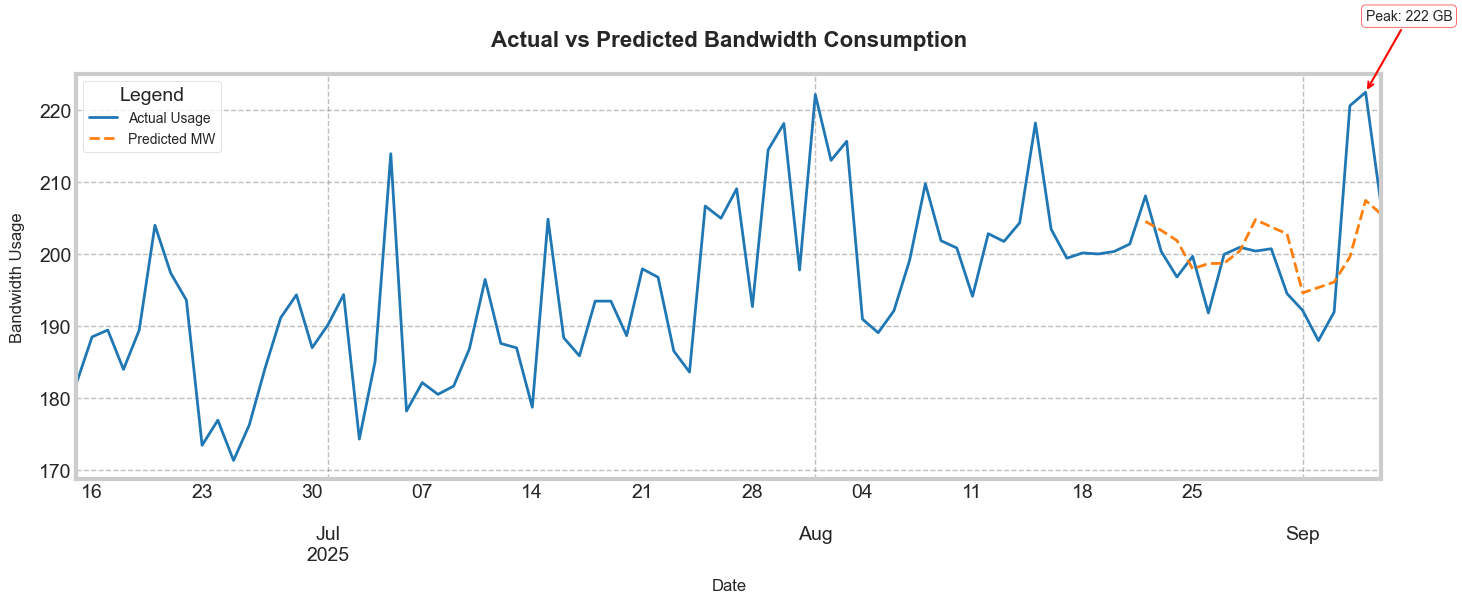

In [20]:
# Make predictions on the test set and add them as a new column in test
test['Bandwidth_Prediction'] = model.predict(X_test)  # Assuming 'model' is your trained model

# Concatenate the test set with predictions and the training set
bandwidth_all = pd.concat([train, test], sort=False)

# Plot the actual vs. predicted energy consumption with improved styling
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the actual values with a solid line
bandwidth_all['peak_bandwidth_utilization'].plot(ax=ax, color='#1f77b4', linewidth=2, label='Actual Usage')

# Plot the predicted values with a dashed line for distinction
bandwidth_all['Bandwidth_Prediction'].plot(ax=ax, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted MW')

# Customize x and y labels
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Bandwidth Usage", fontsize=12, labelpad=10)

# Set a title with larger font and padding
ax.set_title("Actual vs Predicted Bandwidth Consumption", fontsize=16, fontweight='bold', pad=20)

# Adjust the legend for clarity
ax.legend(loc="upper left", fontsize=10, frameon=True, title="Legend")

# Enable grid with light color for readability
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

# Highlight a specific period, if needed (optional)
#highlight_start, highlight_end = "2015-01-01", "2015-02-01"
#ax.axvspan(highlight_start, highlight_end, color="black", alpha=0.1, label="Highlighted Period")

# Add annotations for peak or significant points (optional)
peak_date = bandwidth_all['peak_bandwidth_utilization'].idxmax()  # Find date of max bandwidth usage
peak_value = bandwidth_all['peak_bandwidth_utilization'].max()    # Find max bandwidth usage value
ax.annotate(
    f"Peak: {int(peak_value)} GB",
    xy=(peak_date, peak_value),
    xycoords="data",
    xytext=(peak_date, peak_value + 10),  # Adjust annotation position
    arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.8)
)

# Show the plot
plt.show()

In [ ]:
test.head()

In [21]:
# Function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics on the test set
rmse = mean_squared_error(y_true=test['peak_bandwidth_utilization'], y_pred=test['Bandwidth_Prediction'])
mae = mean_absolute_error(y_true=test['peak_bandwidth_utilization'], y_pred=test['Bandwidth_Prediction'])
mape = mean_absolute_percentage_error(y_true=test['peak_bandwidth_utilization'], y_pred=test['Bandwidth_Prediction'])

print(f"Our RMSE error is {rmse:.2f}")
print(f"Our MAE error is {mae:.2f}")
print(f"Our MAPE error is {mape:.2f}%")

Our RMSE error is 58.64
Our MAE error is 5.53
Our MAPE error is 2.69%


In [22]:
from numbers import Number
# Calculate error columns
test['error'] = test['peak_bandwidth_utilization'] - test['Bandwidth_Prediction']
test['abs_error'] = test['error'].abs()

# Group errors by day and calculate mean errors
#error_by_day = test.groupby(['month', 'dayofmonth'])[test.select_dtypes(include='number').columns()].mean()[['peak_bandwidth_utilization', 'Bandwidth_Prediction', 'error', 'abs_error']]
error_by_day = (
    test.groupby(['month', 'dayofmonth'])
        [test.select_dtypes(include='number').columns]  # keep only numeric columns
        .mean()
)
error_by_day = error_by_day[['peak_bandwidth_utilization',
                             'Bandwidth_Prediction',
                             'error',
                             'abs_error']]

# Display top 10 over-forecasted days
over_forecasted_days = error_by_day.sort_values('error').head(10)
print("Top 10 Over-Forecasted Days:")
display(over_forecasted_days)

# Display top 10 worst absolute predicted days
worst_predicted_days = error_by_day.sort_values('abs_error', ascending=False).head(10)
print("\nTop 10 Worst Absolute Predicted Days:")
display(worst_predicted_days)

# Display top 10 best predicted days
best_predicted_days = error_by_day.sort_values('abs_error').head(10)
print("\nTop 10 Best Predicted Days:")
display(best_predicted_days)

Top 10 Over-Forecasted Days:


peak_bandwidth_utilization  Bandwidth_Prediction     error  \
month dayofmonth                                                               
8     31                              194.52            202.809830 -8.289830   
9     2                               187.99            195.354813 -7.364813   
8     26                              191.83            198.675079 -6.845079   
      24                              196.82            201.870407 -5.050407   
      29                              200.41            204.777237 -4.367237   
9     3                               191.97            196.118362 -4.148362   
8     30                              200.73            203.753052 -3.023052   
      23                              200.36            203.279510 -2.919510   
9     1                               192.17            194.624725 -2.454725   
8     28                              200.94            200.432968  0.507032   

                  abs_error  
month dayofmonth             
8     31           8.289830  
9     2            7.364813  
8     26           6.845079  
      24           5.050407  
      29           4.367237  
9     3            4.148362  
8     30           3.023052  
      23           2.919510  
9     1            2.454725  
8     28           0.507032


Top 10 Worst Absolute Predicted Days:


peak_bandwidth_utilization  Bandwidth_Prediction      error  \
month dayofmonth                                                                
9     4                               220.56            199.588043  20.971957   
      5                               222.43            207.434799  14.995201   
8     31                              194.52            202.809830  -8.289830   
9     2                               187.99            195.354813  -7.364813   
8     26                              191.83            198.675079  -6.845079   
      24                              196.82            201.870407  -5.050407   
      29                              200.41            204.777237  -4.367237   
9     3                               191.97            196.118362  -4.148362   
8     22                              208.06            204.530136   3.529864   
      30                              200.73            203.753052  -3.023052   

                  abs_error  
month dayofmonth             
9     4           20.971957  
      5           14.995201  
8     31           8.289830  
9     2            7.364813  
8     26           6.845079  
      24           5.050407  
      29           4.367237  
9     3            4.148362  
8     22           3.529864  
      30           3.023052


Top 10 Best Predicted Days:


peak_bandwidth_utilization  Bandwidth_Prediction     error  \
month dayofmonth                                                               
8     28                              200.94            200.432968  0.507032   
9     6                               206.55            205.508026  1.041974   
8     27                              199.95            198.718246  1.231754   
      25                              199.68            197.944992  1.735008   
9     1                               192.17            194.624725 -2.454725   
8     23                              200.36            203.279510 -2.919510   
      30                              200.73            203.753052 -3.023052   
      22                              208.06            204.530136  3.529864   
9     3                               191.97            196.118362 -4.148362   
8     29                              200.41            204.777237 -4.367237   

                  abs_error  
month dayofmonth             
8     28           0.507032  
9     6            1.041974  
8     27           1.231754  
      25           1.735008  
9     1            2.454725  
8     23           2.919510  
      30           3.023052  
      22           3.529864  
9     3            4.148362  
8     29           4.367237

,predicted_peak_bandwidth_utilization
2025-09-07,203.480591
2025-09-08,194.259430
2025-09-09,195.446472
2025-09-10,196.239975
2025-09-11,198.371979
2025-09-12,204.980988
2025-09-13,203.775818
2025-09-14,201.748383
2025-09-15,196.720245
2025-09-16,197.700897


Text(0, 0.5, 'Predicted peak bandwidth (Gbps)')

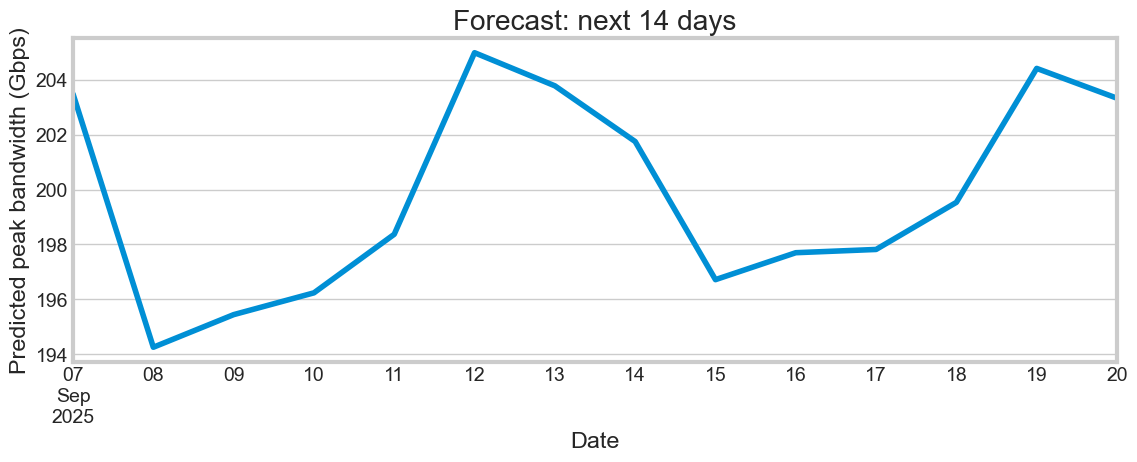

In [23]:
# === Future Forecast (Adjust N_DAYS as needed) ===
# Uses the trained `model` and the same feature engineering to predict future peak_bandwidth_utilization.

import numpy as np
import pandas as pd

# Safety checks
assert 'model' in globals(), "Trained model `model` not found. Run the training cells first."
assert 'df' in globals() and isinstance(df, pd.DataFrame), "`df` not found."
assert 'df_google' in globals(), "`df_google` not found. Re-run data filtering cell."
assert 'create_features' in globals(), "`create_features` function not found."

# Number of future days to predict
N_DAYS = 14  # <-- change this

# Determine the last date from the filtered subset
last_date = pd.to_datetime(df_google.index.max())

# Build empty frame with just an index of future dates
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N_DAYS, freq="D")
future_base = pd.DataFrame(index=future_index)

# create_features expects the same schema as df_google; minimally we only need a datetime index
# so we can pass an empty frame and rely on create_features to add derived columns
future_feats = create_features(future_base.copy())

# Determine the feature columns used by the model
if hasattr(model, "feature_names_in_"):
    feature_cols = list(model.feature_names_in_)
else:
    # Fallback: remove the known target if present, keep numerics
    candidate_cols = future_feats.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in candidate_cols if c != "peak_bandwidth_utilization"]

# Align columns
X_future = future_feats.reindex(columns=feature_cols)

# Predict
y_future = model.predict(X_future)

# Assemble results
forecast_df = pd.DataFrame({
    "predicted_peak_bandwidth_utilization": y_future
}, index=future_index)

display(forecast_df)

# Optional: quick plot
ax = forecast_df["predicted_peak_bandwidth_utilization"].plot(title="Forecast: next {} days".format(N_DAYS), figsize=(12,4))
ax.set_xlabel("Date")
ax.set_ylabel("Predicted peak bandwidth (Gbps)")
